The input to the model is an image that only contains handwritten text. The outputs are bounding boxes that correspond to each line of the text 

The SSD architecture essentially takes image features and repeatedly downsamples the features 

### SSD: Single Shot MultiBox Detector

In [1]:
import difflib
import importlib
import math
import random
import string
#Importing all the required libraries
import pandas as pd
import seaborn as sns
random.seed(123)
import glob
import cv2
from os.path import splitext,basename
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import numpy as np
import os
import sys
import warnings
warnings.simplefilter("ignore")
from imblearn.over_sampling import SMOTE 

pwd = os.getcwd()

In [2]:
from sklearn.datasets import fetch_openml
numbers = fetch_openml('mnist_784', version=1, cache=True)

In [3]:
X_numbers, y_numbers = numbers["data"], numbers["target"]

In [4]:
X_numbers.shape

(70000, 784)

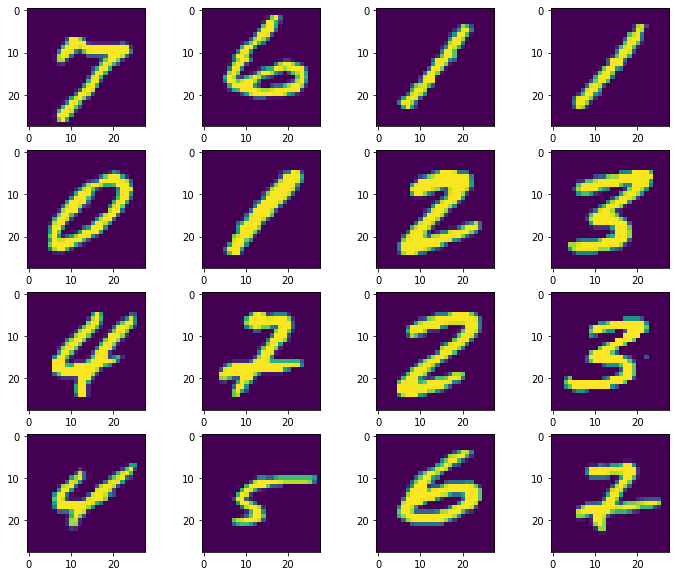

In [5]:
plt.figure(figsize = (12,10))
row, column = 4, 4

for i in range(16): 
    plt.subplot(column, row, i+1)
    some_digit = X_numbers[69000+i]
    some_digit_image = some_digit.reshape(28,28)
    plt.imshow(some_digit_image)
plt.show()

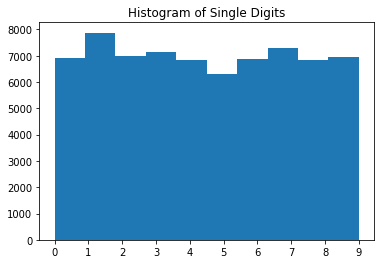

In [7]:
plt.hist(np.sort(y_numbers))
plt.title("Histogram of Single Digits");

In [8]:
# pwd = os.getcwd()
letters_uppercase = pd.read_csv(os.path.basename(pwd + '/az.csv'))

In [12]:
letters_uppercase.rename(columns={'0':'label'}, inplace=True)

In [13]:
# Change label to alphabet
alphabets_mapper = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P'
                    ,16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z'} 
letters_uppercase['label'] = letters_uppercase['label'].map(alphabets_mapper)

In [14]:
X_letters_uppercase = letters_uppercase.drop('label',axis = 1)
y_letters_uppercase = letters_uppercase['label']

In [15]:
X_letters_uppercase.shape

(372450, 784)

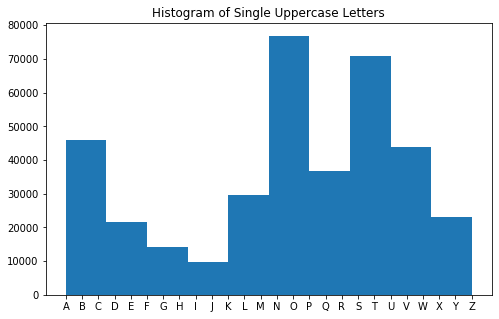

In [17]:
plt.figure(figsize = (8,5))
plt.hist(y_letters_uppercase)
plt.title("Histogram of Single Uppercase Letters");

In [18]:
datadir = pwd+r"\letters-small"
categories = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]

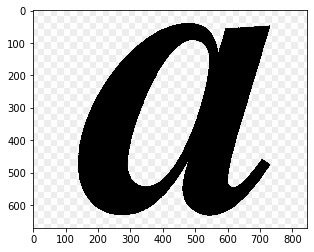

In [19]:
for category in categories:
    path = os.path.join(datadir, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        #check image
        plt.imshow(img_array, cmap="gray")
        plt.show()
        break
    break

In [20]:
img_size = 28
img_size_sq = img_size*img_size

In [21]:
letters_lowercase = []

def create_dataset():
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (img_size, img_size))
                letters_lowercase.append([new_array, category])
            except Exception as e:
                break
create_dataset()


In [22]:
X_letters_lowercase = []
y_letters_lowercase = []

for features, label in letters_lowercase:
    X_letters_lowercase.append(features)
    y_letters_lowercase.append(label)

In [23]:
X_letters_lowercase = np.reshape(X_letters_lowercase,(len(X_letters_lowercase),img_size_sq))

In [24]:
y_letters_lowercase= [str(i) for i in y_letters_lowercase]

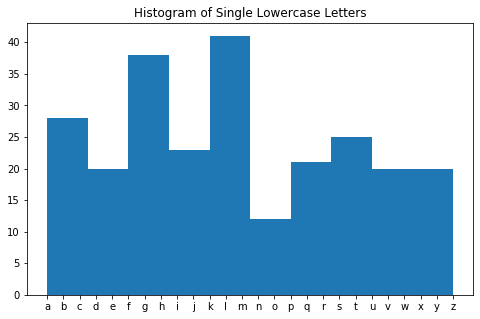

In [26]:
plt.figure(figsize = (8,5))
plt.hist(y_letters_lowercase)
plt.title("Histogram of Single Lowercase Letters");

In [27]:
X = np.concatenate((X_letters_uppercase, X_letters_lowercase, X_numbers), axis=0)
y = np.concatenate((y_letters_uppercase, y_letters_lowercase, y_numbers), axis=0)

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [29]:
y_reshape = y.reshape(-1, 1) #Encoder requires 2d array

In [30]:
#Create the label column
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
y_ord = ordinal_encoder.fit_transform(y_reshape)
y_ord[:10]

array([[10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.]])

In [31]:
#Convert to integer

y_int = y_ord.astype(int)
y_int.dtype

dtype('int32')

In [32]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X_std, y_int, test_size=0.3, shuffle=True)

In [33]:
#sm = SMOTE(random_state = 2) 
#train_x_res, train_y_res = sm.fit_sample(train_x, train_y.ravel()) 

In [34]:
# Reserve 10,000 samples for validation
x_val = train_x[-10000:]
y_val = train_y[-10000:]
train_x = train_x[:-10000]
train_y = train_y[:-10000]
train_x.shape


(299888, 784)

In [35]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

np.random.seed(42) # fix random seed for reproducibility

In [36]:
model1 = Sequential()
model1.add(Dense(50, input_dim=784, activation='relu'))
model1.add(Dense(25, activation='relu'))
model1.add(Dense(10, activation='relu'))
model1.add(Dense(62, activation='softmax')) #we have 36 categories 

In [37]:
# Compile model

#Optimizer:
sgd = keras.optimizers.SGD(lr=0.05)
model1.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                39250     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_3 (Dense)              (None, 62)                682       
Total params: 41,467
Trainable params: 41,467
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Fit the model

history = model1.fit(train_x, train_y, epochs=60, batch_size=100 ,validation_data=(x_val, y_val))


Epoch 1/60
2999/2999 [==============================] - 15s 5ms/step - loss: 0.8358 - accuracy: 0.7776 - val_loss: 0.4634 - val_accuracy: 0.8719
Epoch 2/60
2999/2999 [==============================] - 13s 4ms/step - loss: 0.3667 - accuracy: 0.8993 - val_loss: 0.3482 - val_accuracy: 0.9029
Epoch 3/60
2999/2999 [==============================] - 16s 5ms/step - loss: 0.3043 - accuracy: 0.9163 - val_loss: 0.3120 - val_accuracy: 0.9171
Epoch 4/60
2999/2999 [==============================] - 18s 6ms/step - loss: 0.2731 - accuracy: 0.9240 - val_loss: 0.2960 - val_accuracy: 0.9197
Epoch 5/60
2999/2999 [==============================] - 16s 5ms/step - loss: 0.2518 - accuracy: 0.9300 - val_loss: 0.2660 - val_accuracy: 0.9281
Epoch 6/60
2999/2999 [==============================] - 15s 5ms/step - loss: 0.2362 - accuracy: 0.9331 - val_loss: 0.2656 - val_accuracy: 0.9284
Epoch 7/60
2999/2999 [==============================] - 17s 6ms/step - loss: 0.2242 - accuracy: 0.9367 - val_loss: 0.2433 - val_ac

2999/2999 [==============================] - 4s 1ms/step - loss: 0.1311 - accuracy: 0.9612 - val_loss: 0.2253 - val_accuracy: 0.9436
Epoch 58/60
2999/2999 [==============================] - 4s 1ms/step - loss: 0.1300 - accuracy: 0.9612 - val_loss: 0.2237 - val_accuracy: 0.9429
Epoch 59/60
2999/2999 [==============================] - 4s 1ms/step - loss: 0.1304 - accuracy: 0.9613 - val_loss: 0.2272 - val_accuracy: 0.9432
Epoch 60/60
2999/2999 [==============================] - 4s 1ms/step - loss: 0.1297 - accuracy: 0.9615 - val_loss: 0.2397 - val_accuracy: 0.9414


In [39]:
# evaluate the model

scores = model1.evaluate(test_x, test_y)
print("\n%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))

4151/4151 [==============================] - 5s 1ms/step - loss: 0.2225 - accuracy: 0.9449

accuracy: 94.49%


In [42]:
prediction = model1.predict_classes(test_x)

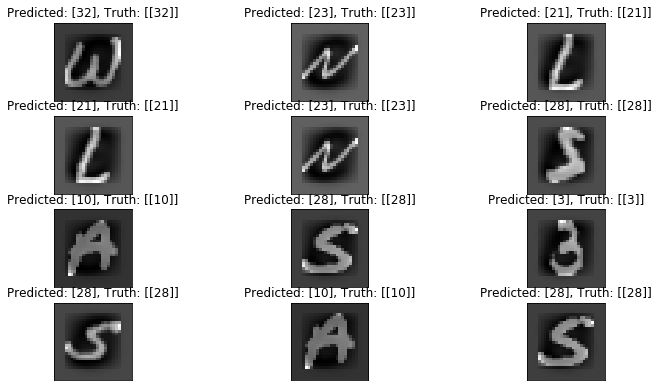

In [45]:
plt.figure(figsize = (12,10))
for i, correct in enumerate(test_y[:12]):
    plt.subplot(6,3,i+1)
    plt.imshow(test_x[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(prediction[correct],
                                        test_y[correct]))
    plt.xticks([])
    plt.yticks([])

# Model Optimization

In [49]:
model2 = Sequential()

model2.add(Dense(100, input_dim=784, activation='relu'))
model2.add(Dense(50, activation='relu'))
model2.add(Dense(25, activation='relu'))

model2.add(Dense(62, activation='sigmoid')) #we have 36 categories
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_14 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_15 (Dense)             (None, 62)                1612      
Total params: 86,437
Trainable params: 86,437
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Compile model

#Optimizer:
sgd= keras.optimizers.SGD(lr=0.05)

model2.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [51]:
# Fit the model

model2_history= model2.fit(train_x, train_y, epochs=50, batch_size=100,validation_data=(x_val, y_val))

Epoch 1/50
2999/2999 [==============================] - 5s 2ms/step - loss: 1.5025 - accuracy: 0.1133 - val_loss: 1.0056 - val_accuracy: 0.1145
Epoch 2/50
2999/2999 [==============================] - 5s 2ms/step - loss: 0.4901 - accuracy: 0.7059 - val_loss: 0.2833 - val_accuracy: 0.9195
Epoch 3/50
2999/2999 [==============================] - 7s 2ms/step - loss: 0.2281 - accuracy: 0.9347 - val_loss: 0.2341 - val_accuracy: 0.9336
Epoch 4/50
2999/2999 [==============================] - 6s 2ms/step - loss: 0.1888 - accuracy: 0.9459 - val_loss: 0.2110 - val_accuracy: 0.9413
Epoch 5/50
2999/2999 [==============================] - 5s 2ms/step - loss: 0.1647 - accuracy: 0.9530 - val_loss: 0.1846 - val_accuracy: 0.9484
Epoch 6/50
2999/2999 [==============================] - 6s 2ms/step - loss: 0.1493 - accuracy: 0.9574 - val_loss: 0.1750 - val_accuracy: 0.9514
Epoch 7/50
2999/2999 [==============================] - 5s 2ms/step - loss: 0.1370 - accuracy: 0.9606 - val_loss: 0.1732 - val_accuracy:

In [52]:
# evaluate the model

scores = model2.evaluate(test_x, test_y)
print("\n%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))

4151/4151 [==============================] - 5s 1ms/step - loss: 0.1648 - accuracy: 0.9640

accuracy: 96.40%


In [53]:
from tensorflow.keras.callbacks import EarlyStopping


earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

callback = [earlystop]

model2.fit(train_x, train_y, validation_data=(test_x, test_y), 
          epochs=100, batch_size=100, callbacks=callback)

Epoch 1/100
2999/2999 [==============================] - 6s 2ms/step - loss: 0.0405 - accuracy: 0.9882 - val_loss: 0.1569 - val_accuracy: 0.9669
Epoch 2/100
2999/2999 [==============================] - 6s 2ms/step - loss: 0.0419 - accuracy: 0.9875 - val_loss: 0.1535 - val_accuracy: 0.9668
Epoch 3/100
2999/2999 [==============================] - 6s 2ms/step - loss: 0.0406 - accuracy: 0.9878 - val_loss: 0.1561 - val_accuracy: 0.9673
Epoch 4/100
2999/2999 [==============================] - 7s 2ms/step - loss: 0.0399 - accuracy: 0.9881 - val_loss: 0.1664 - val_accuracy: 0.9649
Epoch 5/100
2999/2999 [==============================] - 7s 2ms/step - loss: 0.0391 - accuracy: 0.9884 - val_loss: 0.1590 - val_accuracy: 0.9661
Epoch 6/100
2999/2999 [==============================] - 7s 2ms/step - loss: 0.0381 - accuracy: 0.9889 - val_loss: 0.1560 - val_accuracy: 0.9680
Epoch 7/100
2999/2999 [==============================] - 7s 2ms/step - loss: 0.0374 - accuracy: 0.9889 - val_loss: 0.1595 - val_ac

In [54]:
# evaluate the model

scores = model2.evaluate(test_x, test_y)
print("\n%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))

4151/4151 [==============================] - 5s 1ms/step - loss: 0.1595 - accuracy: 0.9665

accuracy: 96.65%


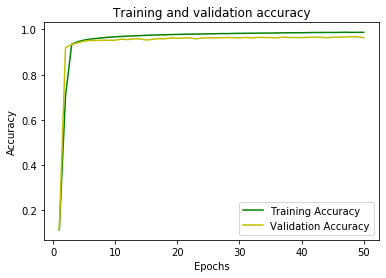

In [55]:
#graph
plt.clf()
accuracy = model2_history.history['accuracy']
val_accuracy = model2_history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'y', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

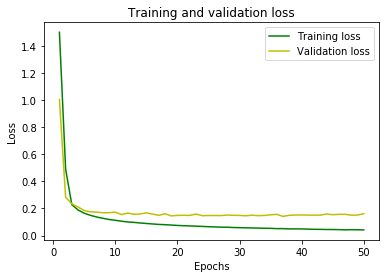

In [56]:
plt.clf()
loss = model2_history.history['loss']
val_loss = model2_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

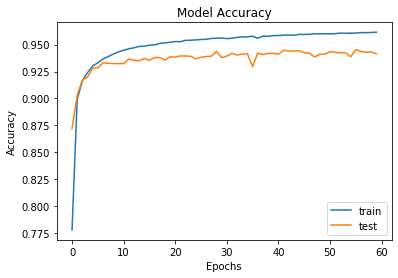

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

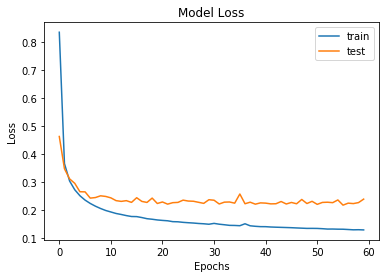

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### Dataset creation

In [59]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

In [60]:
random.seed(1)

## Line/word segmentation

In [61]:

def line_array(array):
    list_x_upper = []
    list_x_lower = []
    for y in range(5, len(array)-5):
        s_a, s_p = strtline(y, array)
        e_a, e_p = endline(y, array)
        print(str(s_a) + ',' + str(s_p) + ',' + str(e_a) + ',' + str(e_p) + ',' + str(y))
        if s_a>=7 and s_p>=5:
            list_x_upper.append(y)
        # bin_img[y][:] = 255
        if e_a>=5 and e_p>=7:
            list_x_lower.append(y)
            # bin_img[y][:] = 255
    return list_x_upper, list_x_lower

def strtline(y, array):
    count_ahead = 0
    count_prev = 0
    for i in array[y:y+10]:
        if i > 3:
            count_ahead+= 1  
    for i in array[y-10:y]:
        if i == 0:
            count_prev += 1  
    return count_ahead, count_prev

def endline(y, array):
    count_ahead = 0
    count_prev = 0
    for i in array[y:y+10]:
        if i==0:
            count_ahead+= 1  
    for i in array[y-10:y]:
        if i >3:
            count_prev += 1  
    return count_ahead, count_prev

def endline_word(y, array, a):
    count_ahead = 0
    count_prev = 0
    for i in array[y:y+2*a]:
        if i < 2:
            count_ahead+= 1  
    for i in array[y-a:y]:
        if i > 2:
            count_prev += 1  
    return count_prev ,count_ahead

def end_line_array(array, a):
    list_endlines = []
    for y in range(len(array)):
        e_p, e_a = endline_word(y, array, a)
        #print(e_p, e_a)
        if e_a >= int(0.8*a) and e_p >= int(0.7*a):
            list_endlines.append(y)
    return list_endlines

def refine_endword(array):
    refine_list = []
    for y in range(len(array)-1):
        if array[y]+1 < array[y+1]:
            refine_list.append(array[y])
    refine_list.append(array[-1])
    return refine_list


def refine_array(array_upper, array_lower):
    upperlines = []
    lowerlines = []
    for y in range(len(array_upper)-1):
        if array_upper[y] + 5 < array_upper[y+1]:
            upperlines.append(array_upper[y]-10)
    for y in range(len(array_lower)-1):
        if array_lower[y] + 5 < array_lower[y+1]:
            lowerlines.append(array_lower[y]+10)

    upperlines.append(array_upper[-1]-10)
    lowerlines.append(array_lower[-1]+10)
    
    return upperlines, lowerlines

def letter_width(contours):
    letter_width_sum = 0
    count = 0
    for cnt in contours:
        if cv2.contourArea(cnt) > 20:
            x,y,w,h = cv2.boundingRect(cnt)
            letter_width_sum += w
            count += 1

    return letter_width_sum/count


def end_wrd_dtct(final_local, i, bin_img, mean_lttr_width):
    count_y = np.zeros(shape = width)
    for x in range(width):
        for y in range(final_local[i],final_local[i+1]):
            if bin_img[y][x] == 255:
                count_y[x] += 1
    #end_lines = end_line_array(count_y, int(mean_lttr_width))
    #endlines = refine_endword(end_lines)
    #print(i)
    '''for x in range(len(count_y)):
        if max(count_y[0:x+1]) >= 3 and max(count_y[x:]) >= 3 and (20-np.count_nonzero(count_y[x-10:x+10])) > 6:
            print(x)'''

#     chalu_img, 
    contours, hierarchy = cv2.findContours(lines_img[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    letter_width_sum = 0
    count = 0
    for cnt in contours:
        if cv2.contourArea(cnt) > 20:
            x, y, w, h = cv2.boundingRect(cnt)
            letter_width_sum += w
            count += 1
    if count != 0 :
        mean_width = letter_width_sum / count
    else:
        mean_width = 0
    #print(mean_width)
    spaces = []
    line_end = []
    for x in range(len(count_y)):
        number = int(0.5*int(mean_width)) - np.count_nonzero(count_y[x-int(0.25*int(mean_width)):x+int(0.25*int(mean_width))])
        if max(count_y[0:x + 1]) >= 3 and number >= 0.4*int(mean_width):
            spaces.append(x)
        if max(count_y[x:]) <= 2:
            line_end.append(x)
    true_line_end = min(line_end) + 10
    #spaces = refine_endword(spaces)
    #print(spaces)
    #print(true_line_end)
    reti = []
    final_spaces = []
    for j in range(len(spaces)):
        if spaces[j] < true_line_end:
            if spaces[j] == spaces[j-1] + 1:
                reti.append(spaces[j-1])
            elif spaces[j] != spaces[j-1] + 1 and spaces[j-1] == spaces[j-2] +1:
                reti.append(spaces[j-1])
                retiavg = int(sum(reti)/len(reti))
                final_spaces.append(retiavg)
                reti = []
            elif spaces[j] != spaces[j-1] + 1 and spaces[j-1] != spaces[j-2] +1 and spaces[j] != spaces[j+1] -1:
                final_spaces.append(spaces[j])
        elif spaces[j] == true_line_end:
            final_spaces.append(true_line_end)
    #print(final_spaces)
    for x in final_spaces:
        final_thr[final_local[i]:final_local[i+1], x] = 255
    return final_spaces


def letter_seg(lines_img, x_lines, i):
    copy_img = lines_img[i].copy()
    x_linescopy = x_lines[i].copy()
    
    letter_img = []
    letter_k = []
    
#     chalu_img, 
    contours, hierarchy = cv2.findContours(copy_img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)   
    for cnt in contours:
        if cv2.contourArea(cnt) > 5:
            x,y,w,h = cv2.boundingRect(cnt)
            # letter_img.append(lines_img[i][y:y+h, x:x+w])
            letter_k.append((x,y,w,h))

    letter_width_sum = 0
    count = 0
    for cnt in contours:
        if cv2.contourArea(cnt) > 20:
            x, y, w, h = cv2.boundingRect(cnt)
            letter_width_sum += h
            count += 1

    #mean_height = letter_width_sum/count

    letter = sorted(letter_k, key=lambda student: student[0])

    for e in range(len(letter)):
        if e < len(letter)-1:
            if abs(letter[e][0] - letter[e+1][0]) <= 2:
                x,y,w,h = letter[e]
                x2,y2,w2,h2 = letter[e+1]
                if h >= h2:
                    letter[e] = (x,y2,w,h+h2)
                    letter.pop(e+1)
                elif h < h2:
                    letter[e+1] = (x2,y,w2,h+h2)
                    letter.pop(e)

    for e in range(len(letter)):
        letter_img_tmp = lines_img[i][letter[e][1]-0:letter[e][1]+letter[e][3]+0,letter[e][0]-0:letter[e][0]+letter[e][2]+0]
        letter_img_tmp = cv2.resize(letter_img_tmp, dsize=(28, 28), interpolation=cv2.INTER_AREA)
        width = letter_img_tmp.shape[1]
        height = letter_img_tmp.shape[0]
        count_y = np.zeros(shape=(width))
        for x in range(width):
            for y in range(height):
                if letter_img_tmp[y][x] == 255:
                    count_y[x] = count_y[x] +1
        print(count_y)
        max_list = []
        for z in range(len(count_y)):
            if z>=5 and z<= len(count_y)-6:
                if max(count_y[z-5:z+6]) == count_y[z] and count_y[z] >= 2:
                    max_list.append(z)
            elif z<5:
                if max(count_y[0:z+6]) == count_y[z] and count_y[z] >= 2:
                    max_list.append(z)
            elif z > len(count_y)-6:
                if max(count_y[z-5:len(count_y)-1]) == count_y[z] and count_y[z] >= 2:
                    max_list.append(z)
        print(max_list)
        rem_list = []
        final_max_list = []
        for z in range(len(max_list)):
            if z > 0:
                if max_list[z]-max_list[z-1] <= 3:
                    rem_list.append(z-1)
        for z in range(len(max_list)):
            if z not in rem_list:
                final_max_list.append(max_list[z])
        print(final_max_list)
        if len(final_max_list) <= 1:
            print(False)
        else:
            max_len = len(final_max_list) - 1
            for j in range(max_len):
                list = count_y[final_max_list[j]:final_max_list[j+1]]
                min_list = sorted(list)[:3]
                avg = sum(min_list)/len(min_list)
                print(avg)



    x_linescopy.pop(0)
    word = 1
    letter_index = 0
    for e in range(len(letter)):
        #print(str(letter[e][0]) + ',' + str(letter[e][1]) + ',' + str(letter[e][2]) + ',' + str(letter[e][3]) + ',' + str(e))
        if(letter[e][0]<x_linescopy[0]):
            letter_index += 1
            letter_img_tmp = lines_img[i][letter[e][1]-0:letter[e][1]+letter[e][3]+5,letter[e][0]-2:letter[e][0]+letter[e][2]+2]
            letter_img = cv2.resize(letter_img_tmp, dsize =(28, 28), interpolation = cv2.INTER_AREA)
            cv2.imwrite('./segmented_img/img1/'+str(i+1)+'_'+str(word)+'_'+str(letter_index)+'.jpg', 255-letter_img)
        else:
            x_linescopy.pop(0)
            word += 1
            letter_index = 1
            letter_img_tmp = lines_img[i][letter[e][1]-0:letter[e][1]+letter[e][3]+5,letter[e][0]-2:letter[e][0]+letter[e][2]+2]
            letter_img = cv2.resize(letter_img_tmp, dsize =(28, 28), interpolation = cv2.INTER_AREA)
            cv2.imwrite('./segmented_img/img1/'+str(i+1)+'_'+str(word)+'_'+str(letter_index)+'.jpg', 255-letter_img)
            


In [81]:
src_img= cv2.imread(pwd+r'/Hi.jpeg', 1)
copy = src_img.copy()
height = src_img.shape[0]
width = src_img.shape[1]
#  Resizing Image
src_img = cv2.resize(copy, dsize =(1320, int(1320*height/width)), interpolation = cv2.INTER_AREA)
height = src_img.shape[0]
width = src_img.shape[1]

In [82]:
print("#---------Image Info:--------#")
print("\tHeight =",height,"\n\tWidth =",width)
print("#----------------------------#")

#---------Image Info:--------#
	Height = 683 
	Width = 1320
#----------------------------#


In [83]:
grey_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)

# Applying Adaptive Threshold with kernel :- 21 X 21
bin_img = cv2.adaptiveThreshold(grey_img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,21,20)
coords = np.column_stack(np.where(bin_img > 0))
angle = cv2.minAreaRect(coords)[-1]
if angle < -45:
    angle = -(90 + angle)
else:
    angle = -angle
h = bin_img.shape[0]
w = bin_img.shape[1]
center = (w//2,h//2)
angle = 0
M = cv2.getRotationMatrix2D(center,angle,1.0)
bin_img = cv2.warpAffine(bin_img,M,(w,h),
                         flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

bin_img1 = bin_img.copy()
bin_img2 = bin_img.copy()

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
kernel1 = np.array([[1,0,1],[0,1,0],[1,0,1]], dtype = np.uint8)
final_thr = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel)
contr_retrival = final_thr.copy()

In [84]:
# Beginning Character Segmentation
count_x = np.zeros(shape= (height))
for y in range(height):
    for x in range(width):
        if bin_img[y][x] == 255 :
            count_x[y] = count_x[y]+1

local_minima = []
for y in range(len(count_x)):
    if y >= 10 and y <= len(count_x)-11:
        arr1 = count_x[y-10:y+10]
    elif y < 10:
        arr1 = count_x[0:y+10]
    else:
        arr1 = count_x[y-10:len(count_x)-1]
    if min(arr1) == count_x[y]:
        local_minima.append(y)

In [85]:
final_local = []
init = []
end = []
for z in range(len(local_minima)):
    if z != 0 and z!= len(local_minima)-1:
        if local_minima[z] != (local_minima[z-1] +1) and local_minima[z] != (local_minima[z+1] -1):
            final_local.append(local_minima[z])
        elif local_minima[z] != (local_minima[z-1] + 1) and local_minima[z] == (local_minima[z+1] -1):
            init.append(local_minima[z])
        elif local_minima[z] == (local_minima[z-1] + 1) and local_minima[z] != (local_minima[z+1] -1):
            end.append(local_minima[z])
    elif z == 0:
        if local_minima[z] != (local_minima[z+1]-1):
            final_local.append(local_minima[z])
        elif local_minima[z] == (local_minima[z+1]-1):
            init.append(local_minima[z])
    elif z == len(local_minima)-1:
        if local_minima[z] != (local_minima[z-1]+1):
            final_local.append(local_minima[z])
        elif local_minima[z] == (local_minima[z-1]+1):
            end.append(local_minima[z])
for j in range(len(init)):
    mid = (init[j] + end[j])/2
    if (mid % 1) != 0:
        mid = mid+0.5
    final_local.append(int(mid))

In [86]:
# final_local = sorted(final_local)
no_of_lines = len(final_local) - 1
print("\nGiven Text has   # ",no_of_lines, " #   no. of Characters")
lines_img = []


Given Text has   #  17  #   no. of Characters



Average Width of Each Letter:-  61.5


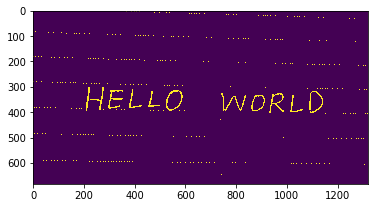

In [87]:
for i in range(no_of_lines):
    lines_img.append(bin_img2[final_local[i]:final_local[i+1], :])

contours, hierarchy = cv2.findContours(contr_retrival,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
final_contr = np.zeros((final_thr.shape[0],final_thr.shape[1],3), dtype = np.uint8)
cv2.drawContours(src_img, contours, -1, (0,255,0), 1)
mean_lttr_width = letter_width(contours)
plt.imshow(final_thr)
print("\nAverage Width of Each Letter:- ", mean_lttr_width)

In [88]:
x_lines = []

for i in range(len(lines_img)):
    x_lines.append(end_wrd_dtct(final_local, i, bin_img, mean_lttr_width))

for i in range(len(x_lines)):
    x_lines[i].append(width)

In [89]:
#-------------Letter Segmentation-------------#
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts


chr_img = bin_img1.copy()
contours, hierarchy = cv2.findContours(chr_img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
# digit_w, digit_h = 30, 60
digit_w, digit_h = 28, 28
crop_characters = []

for cnt in sort_contours(contours):
    
    if cv2.contourArea(cnt) > 20: 
        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(src_img,(x,y),(x+w,y+h),(0,255,0),2)

        curr_num = final_thr[y:y+h,x:x+w]
        curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
        _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        crop_characters.append(curr_num)

<Figure size 1008x288 with 0 Axes>

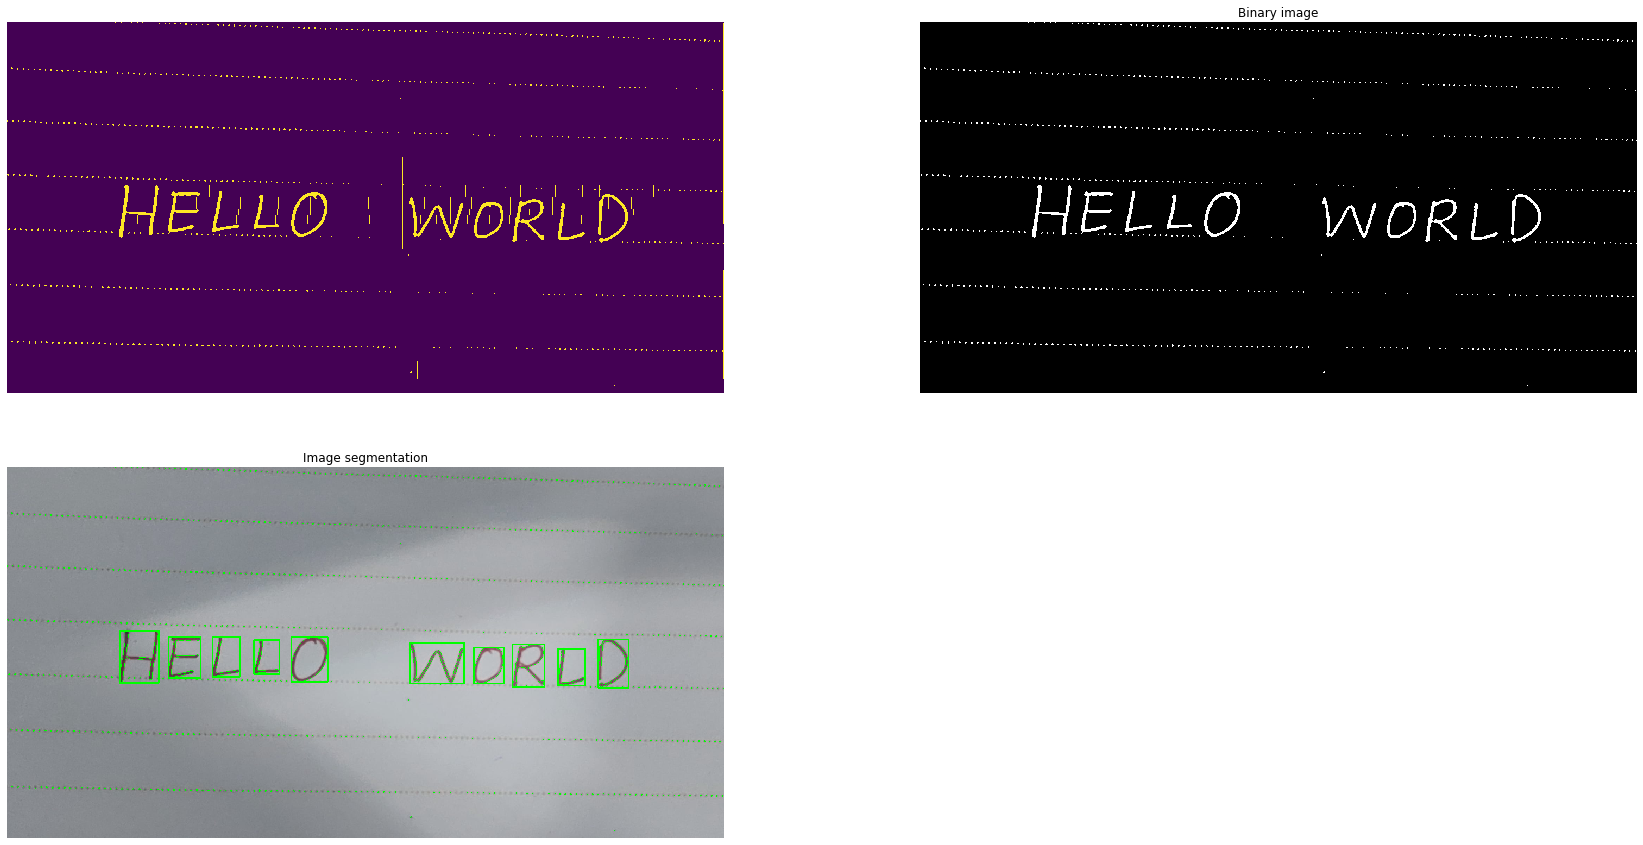

In [90]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)
plot_image = [ final_thr, bin_img, src_img]
plot_name = ["","Binary image","Image segmentation"]

fig = plt.figure(figsize=(30,15)) 
grid = gridspec.GridSpec(ncols=2,nrows=2,figure = fig)
for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

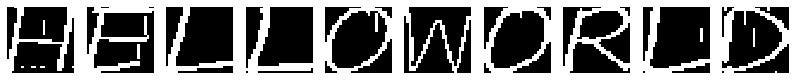

In [91]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)
# plt.imshow(crop_characters[0],cmap="gray")

for i in range(len(crop_characters)):

    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")

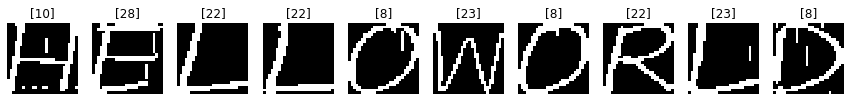

In [92]:
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    crop_characters[i]=crop_characters[i]/255
    crop_characters[i] = np.reshape(crop_characters[i],[1,784])
    
    title = model1.predict_classes(crop_characters[i])
    plt.title("{}".format(title))
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)


In [93]:
from tensorflow.keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
json_file = open(pwd+r'\MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(pwd+r'\License_character_recognition_weight.h5')
model.summary()
labels = LabelEncoder()
labels.classes_ = np.load(pwd+r'\license_character_classes.npy')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 81, 81, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 40, 40, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 40, 40, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

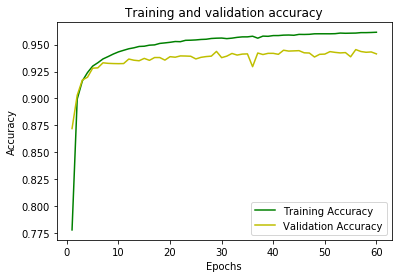

In [94]:
plt.clf()
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'y', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Loading model successfully...
C:\Users\shrad\Desktop\BAIS\DSP\project\Final\Cars252.png
Detect 1 plate(s) in Cars252
Coordinate of plate(s) in image: 
 [array([[172.19706319, 313.93768845, 313.16277802, 171.42215275],
       [237.58743449, 238.71365207, 271.13958902, 270.01337143],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


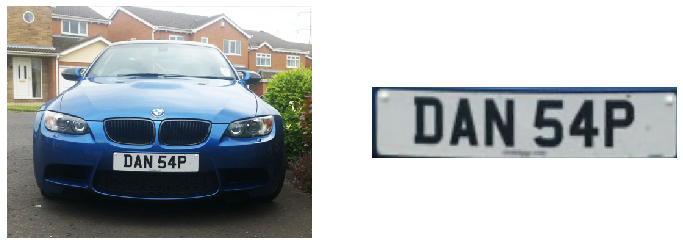

In [95]:
from local_utils import detect_lp
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)
        
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

test_image = pwd+r'\Cars252.png'
print(test_image)
LpImg,cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

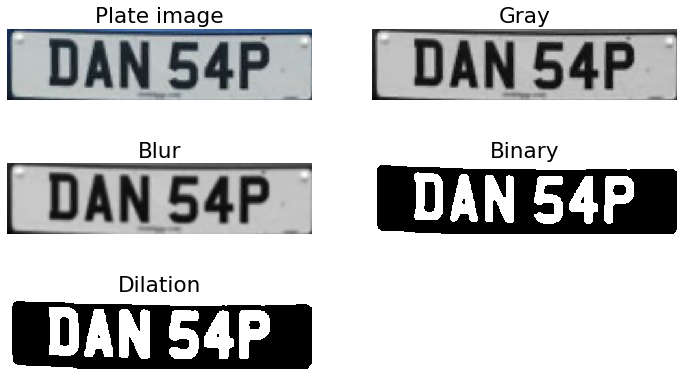

In [96]:
 #check if there is at least one license image
# Scales, calculates absolute values, and converts the result to 8-bit.
plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))

# convert to grayscale and blur the image
gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(7,7),0)

# Applied inversed thresh_binary 
binary = cv2.threshold(blur, 180, 255,
                     cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["Plate image","Gray","Blur","Binary","Dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

Detect 6 letters...


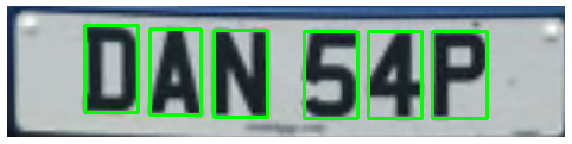

In [97]:
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)

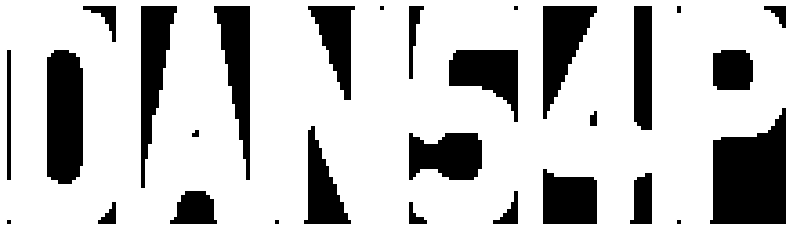

In [98]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")

In [99]:
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

DAN54P


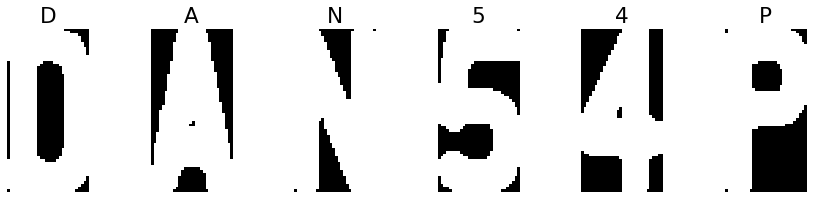

In [100]:
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)

License plate Recogniton 

In [101]:
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
json_file = open(pwd+r'\MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(pwd+r'\License_character_recognition_weight.h5')
model.summary()
labels = LabelEncoder()
labels.classes_ = np.load(pwd+r'\license_character_classes.npy')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 81, 81, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 40, 40, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 40, 40, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

Loading model successfully...
C:\Users\shrad\Desktop\BAIS\DSP\project\Final\Cars252.png
Detect 1 plate(s) in Cars252
Coordinate of plate(s) in image: 
 [array([[172.19706319, 313.93768845, 313.16277802, 171.42215275],
       [237.58743449, 238.71365207, 271.13958902, 270.01337143],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


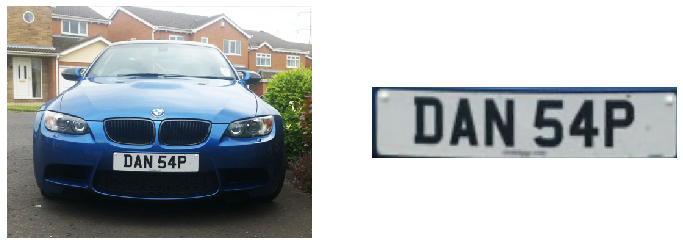

In [102]:

from local_utils import detect_lp
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)
        
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

test_image = pwd+r'\Cars252.png'
print(test_image)
LpImg,cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

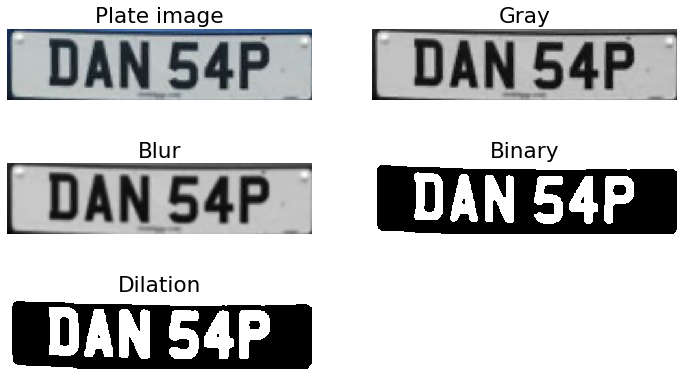

In [103]:
 #check if there is at least one license image
# Scales, calculates absolute values, and converts the result to 8-bit.
plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))

# convert to grayscale and blur the image
gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(7,7),0)

# Applied inversed thresh_binary 
binary = cv2.threshold(blur, 180, 255,
                     cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["Plate image","Gray","Blur","Binary","Dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

Detect 6 letters...


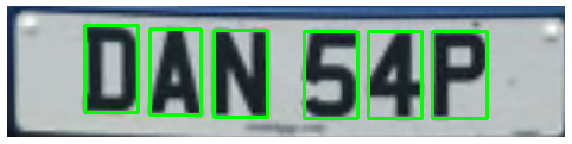

In [104]:
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)

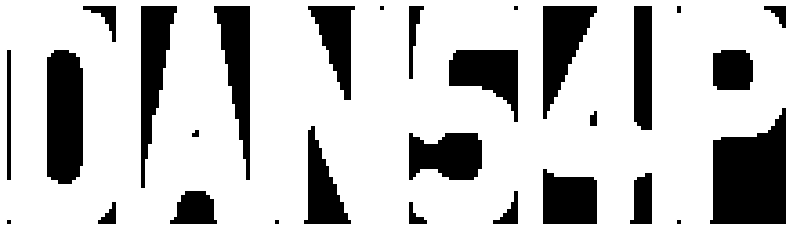

In [105]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")

In [106]:
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

DAN54P


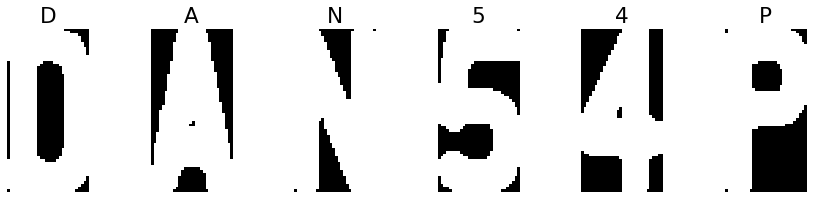

In [107]:
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)